# This notebook is a demo version and trains the model using sample data.
# Therefore, the output results in the cells below may not be reproducible.

In [ ]:
from rdkit import Chem

import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from tqdm.auto import tqdm

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumHBA
from rdkit.Chem.rdMolDescriptors import CalcNumHBD
import os
import matplotlib.pyplot as plt

## bring processed & filtered DB

In [ ]:
united = pd.read_csv('./DB/collecting/filtered_data/dummy_100_data.csv')
# salt 데이터 삭제
united = united[united['Smiles'].str.find('.')==-1]
# 중복 데이터 평균 내기
united = united.groupby(
    by=['Smiles', 'elu1_smiles', 'elu2_smiles', 'ratio1', 'ratio2'],
    as_index=False
).agg({
    'Rf': 'mean',
    'Rf_type': lambda x: 'C' if any(val == 'C' for val in x) else 'Q',
    'DataSource': lambda x: 'D4C' if 'D4C' in x.values else x.values[0],
    'doi': lambda x: x.iloc[0] if len(x) == 1 else 'average of several papers'
})

In [6]:
united

,Smiles,elu1_smiles,elu2_smiles,ratio1,ratio2,Rf,Rf_type,DataSource,doi
0,Br/C(=C\C1SCCCS1)c1ccccc1,CCCCCC,CCOC(C)=O,0.937438,0.062562,0.58,C,D4C,average of several papers
1,Br/C(=C\n1cc(-c2ccccc2)nn1)c1ccccc1,CCCCCC,CCOC(C)=O,0.789299,0.210701,0.60,Q,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.4...
2,BrC#Cc1ccc(-n2c3ccccc3c3ccccc32)cc1,CCCCCC,CCOC(C)=O,0.882244,0.117756,0.30,Q,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...
3,BrC#Cc1ccc(C#Cc2ccccc2)cc1,CCCCCC,CCOC(C)=O,0.937438,0.062562,0.40,Q,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...
4,BrC#Cc1ccc2c(c1)CC2,CCCCCC,CCOC(C)=O,0.986828,0.013172,0.70,Q,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...
...,...,...,...,...,...,...,...,...,...
43703,c1csc(C2CCCCN2)c1,CCOC(C)=O,CO,0.788480,0.211520,0.24,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.2...
43704,c1csc(C2CCOC2)c1,CCCCCC,CCOC(C)=O,0.428314,0.571686,0.66,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...
43705,c1csc(CN2CCOCC2)c1,CCCCCC,CCOC(C)=O,0.529149,0.470851,0.30,Q,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...
43706,c1ncc(-c2ccc(CN3CCOCC3)cc2)cn1,ClCCl,CO,0.893808,0.106192,0.29,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...


## 사용할 데이터만 추리기

In [ ]:
from decimal import Decimal

def is_it_quantized(num):
    a = Decimal(str(num)) % Decimal("0.05") # 문자를 Decimal로 변환시킨 수를 사용해야 부동소수점 오차 안남.
    if a > 0:
        return False
    else:
        return True

def data_scoop(data_df):
    data_df_ = data_df.copy()
    print("C_paper (or data) / Q_data (or data) / D4C / benchmark / all 중 선택")
    w= input("C_paper (or data) / Q_data (or data) / D4C / benchmark / all 중 선택")
    if w == 'C_paper':
        s_data = data_df_[data_df_['Rf_type']=='C']
    elif w == 'C_data':
        q_mask = data_df_['Rf'].apply(is_it_quantized)
        s_data = data_df[~q_mask]

    elif w == 'Q_paper':
        s_data = data_df_[data_df_['Rf_type']=='Q']
    elif w == 'Q_data':
        s_data = data_df_[q_mask]

    elif w == 'D4C':
        s_data = data_df_[data_df_['DataSource'] =='D4C']
    elif w == 'benchmark':
        s_data = data_df_[data_df_['DataSource'] =='benchmark']

    elif w == 'all':
        s_data = data_df_
    else:
        print('뭐 쓸건지 제대로 고르시오! 잘못 골랐거나 안골랐음!')
        return 
    print(f'{w} 골랐음!')
    return s_data

united_ = data_scoop(united)
united_.reset_index(drop=True, inplace=True)

C_paper (or data) / Q_data (or data) / D4C / benchmark / all 중 선택
C_paper 골랐음!


# mean, variance update

In [ ]:
# 여기선 평균, 표준편차만 저장하고 표준화는 graph만들면서 진행

def standardization(DB_df, columns_list, backup=False):
    # columns_list : list of prop

    mean = DB_df[columns_list].mean(axis=0)
    std = DB_df[columns_list].std(axis=0)
    if backup==True:
        np.save('standardization/backup/mean_backup.npy', np.array(mean, dtype = np.float32))
        np.save('standardization/backup/std_backup.npy', np.array(std, dtype = np.float32))
    else:
        np.save('standardization/mean.npy', np.array(mean, dtype = np.float32))
        np.save('standardization/std.npy', np.array(std, dtype = np.float32))
        
    return None


def inverse_standardization(pred_nd_array, mean, std):
    return pred_nd_array * std + mean


# 라벨의 평균, 분산 업데이트
standardization(united_, ['Rf'])

# Train/Valid split

In [ ]:
# split 하기 전에, 나중에 학습 후 datapoint별 추적을 의한 sample_id 지정해두기
united_.loc[:,'sample_id'] = united_.index

# 데이터 타입 분리
d4c = united_[united_['DataSource'] == 'D4C']
benchmark = united_[united_['DataSource'] == 'benchmark']
print(f'd4c: {len(d4c)}개, benchmark: {len(benchmark)}개')

d4c: 11229개, benchmark: 3482개


In [ ]:
def make_test_set_split_only_by_mol(data, test_ratio, random_state=42):

    mol_class = data["Smiles"].drop_duplicates()
    mol_train = mol_class.sample(frac=(1 - test_ratio), random_state=random_state)
    mol_test = mol_class.drop(index=mol_train.index)

    # 3. isin()으로 필터링 - concat 반복 제거
    train_set = data[data["Smiles"].isin(mol_train)].copy()
    test_set = data[data["Smiles"].isin(mol_test)].copy()
    
    # 4. 인덱스 정리
    train_set.reset_index(drop=True, inplace=True)
    test_set.reset_index(drop=True, inplace=True)

    return train_set, test_set


# d4c, nat data 에서 일정 비율로 train/valid 나눠서 일정 비율로 train/valid 구성

train_set1, valid_set1 = make_test_set_split_only_by_mol(d4c, 0.2)
valid_set1, test_set1 = make_test_set_split_only_by_mol(valid_set1, 0.5)

train_set2, valid_set2 = make_test_set_split_only_by_mol(benchmark, 0.2)
valid_set2, test_set2 = make_test_set_split_only_by_mol(valid_set2, 0.5)

train_set = pd.concat([train_set1, train_set2], axis=0).reset_index(drop=True)
valid_set = pd.concat([valid_set1, valid_set2], axis=0).reset_index(drop=True)
test_set = pd.concat([test_set1, test_set2], axis=0).reset_index(drop=True)

In [18]:
path_raw = './DB/Rf'
train_set.to_csv(path_raw + '/United_DB_train.csv', index=False)
valid_set.to_csv(path_raw + '/United_DB_valid.csv', index=False)
test_set.to_csv(path_raw + '/United_DB_test.csv', index=False)

In [19]:
path_raw = './DB/Rf'
train_set = pd.read_csv(path_raw + '/United_DB_train.csv')
valid_set = pd.read_csv(path_raw + '/United_DB_valid.csv')
test_set = pd.read_csv(path_raw + '/United_DB_test.csv')
print(f'trainset: {len(train_set)}개 / validset: {len(valid_set)}개 / testset: {len(test_set)}개')

trainset: 11797개 / validset: 1440개 / testset: 1474개


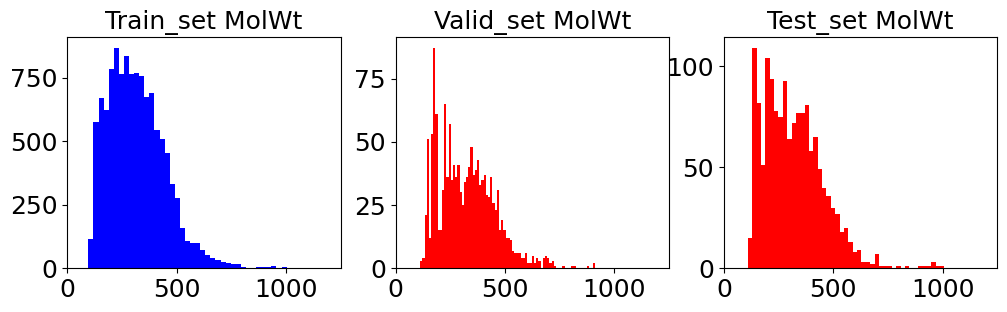

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
title = ['Train_set MolWt', 'Valid_set MolWt', 'Test_set MolWt']
bin_n = 80
for i, dataset in enumerate([train_set, valid_set, test_set]):    
    if i ==0:
        color = 'blue'
    elif i ==1:
        color = 'red'
    molwt_list = [Descriptors.MolWt(Chem.MolFromSmiles(smiles)) for smiles in pd.Series(dataset['Smiles'])]
    axs[i%3].hist(molwt_list, bins=bin_n, color = color)
    axs[i%3].set_title(title[i], fontsize=18)
    axs[i%3].tick_params(axis='x', labelsize=18)
    axs[i%3].tick_params(axis = 'y', labelsize=18)
    #axs[i%3].set_xlim(0,1250)
plt.show()

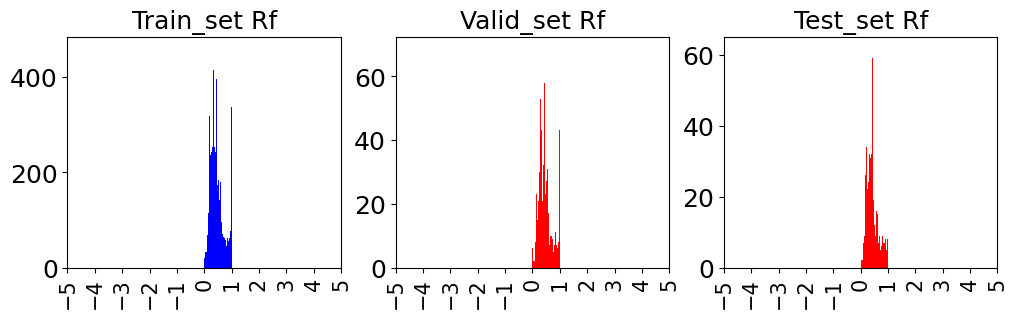

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
title = ['Train_set Rf', 'Valid_set Rf', 'Test_set Rf']
for i, dataset in enumerate([train_set, valid_set, test_set]):    
    if i ==0:
        color = 'blue'
    elif i ==1:
        color = 'red'
    axs[i%3].hist(dataset['Rf'], bins=80, color = color)
    axs[i%3].set_title(title[i], fontsize=18)
    axs[i%3].tick_params(axis='x', labelsize=15, rotation =90 )
    axs[i%3].tick_params(axis = 'y', labelsize=18)

    # axs[i%3].set_xlim(-0.1,1.1)
    # axs[i%3].set_xticks(np.linspace(0,1,11)) 

    axs[i%3].set_xlim(-0.1,1.1)
    axs[i%3].set_xticks(np.linspace(0,1,11))

plt.show()

/tmp/ipykernel_4073083/2221055597.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i%3].set_xticklabels(elu_combi_count.index, rotation=45, ha='right')
/tmp/ipykernel_4073083/2221055597.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i%3].set_xticklabels(elu_combi_count.index, rotation=45, ha='right')
/tmp/ipykernel_4073083/2221055597.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i%3].set_xticklabels(elu_combi_count.index, rotation=45, ha='right')


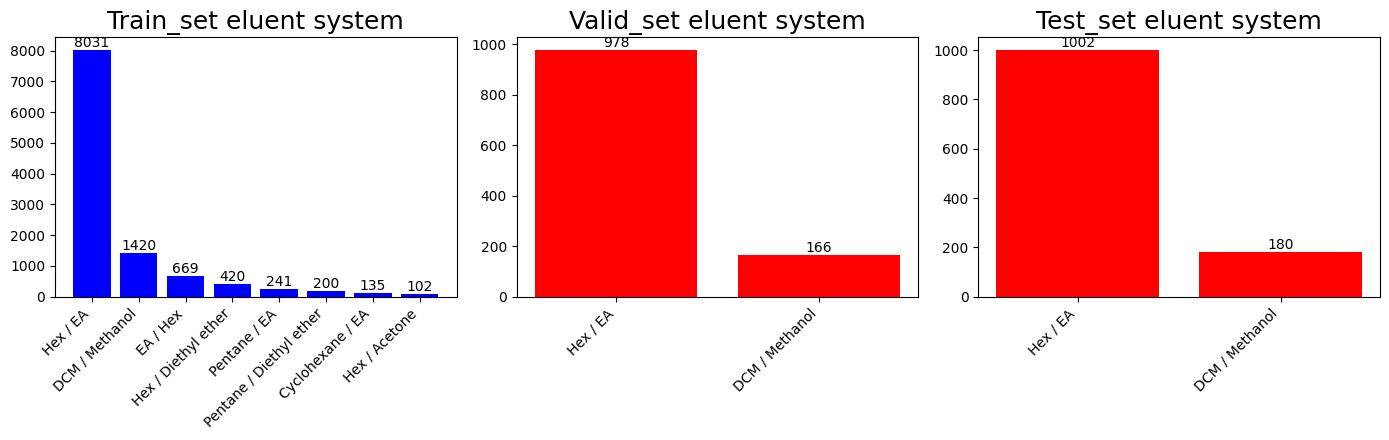

In [ ]:
elu_inform = pd.read_csv('./DB/data_process/eluent_standard.csv')
smiles2name_converter = dict(zip(elu_inform['hex_Smiles'], elu_inform['std_name']))

fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))

title = ['Train_set eluent system', 'Valid_set eluent system', 'Test_set eluent system']
for i, dataset in enumerate([train_set, valid_set, test_set]):  
    if i ==0:
        color = 'blue'
    elif i ==1:
        color = 'red'
    elu_combi = [' / '.join([str(smiles2name_converter[dataset.iloc[i,1]]),str(smiles2name_converter[dataset.iloc[i,2]])]) for i in range(len(dataset))]
    elu_combi = [e[:-5] if e.find('nan')!=-1 else e for e in elu_combi]
    elu_combi_count = pd.Series(elu_combi).value_counts()

    axs[i%3].bar(elu_combi_count.index, elu_combi_count, color = color)
    axs[i%3].set_title(title[i], fontsize=18)
    axs[i%3].set_xticklabels(elu_combi_count.index, rotation=45, ha='right')
    for ii, v in enumerate(elu_combi_count):
        axs[i%3].text(ii, v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Make graph

In [ ]:
# Rf 라벨 사용

from make_graph_dataloader import MolToGraph

path_raw = './DB/Rf'
compound_train_set = MolToGraph('Smiles', path_raw, 'United_DB_train.csv', 'compound_train.pt', molecular_param = False)
compound_valid_set = MolToGraph('Smiles', path_raw, 'United_DB_valid.csv', 'compound_valid.pt', molecular_param = False)
compound_test_set = MolToGraph('Smiles', path_raw, 'United_DB_test.csv', 'compound_test.pt', molecular_param = False)

elu1_train_set = MolToGraph('elu1_smiles', path_raw, 'United_DB_train.csv', 'elu1_train.pt', molecular_param = False)
elu1_valid_set = MolToGraph('elu1_smiles', path_raw, 'United_DB_valid.csv', 'elu1_valid.pt', molecular_param = False)
elu1_test_set = MolToGraph('elu1_smiles', path_raw, 'United_DB_test.csv', 'elu1_test.pt', molecular_param = False)

elu2_train_set = MolToGraph('elu2_smiles', path_raw, 'United_DB_train.csv', 'elu2_train.pt', molecular_param = False)
elu2_valid_set = MolToGraph('elu2_smiles', path_raw, 'United_DB_valid.csv', 'elu2_valid.pt', molecular_param = False)
elu2_test_set = MolToGraph('elu2_smiles', path_raw, 'United_DB_test.csv', 'elu2_test.pt', molecular_param = False)

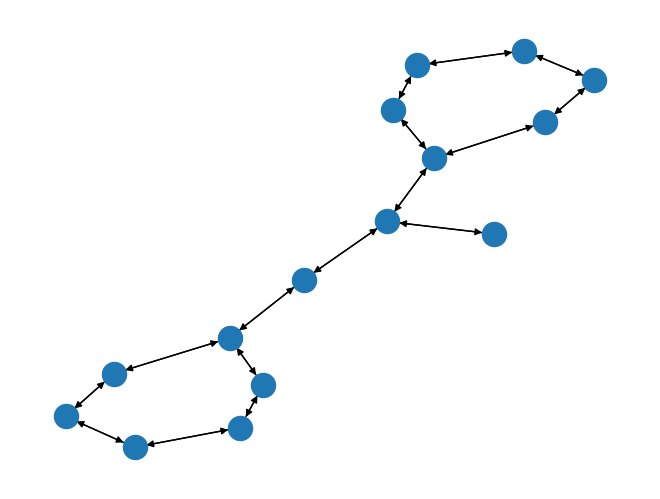

In [31]:
from torch_geometric.utils import to_networkx
from networkx import draw
g = to_networkx(compound_train_set[0])
draw(g)

## dataloader

In [34]:
from make_graph_dataloader import TripleGraphDataset

graph_train_set = TripleGraphDataset(
    compound_train_set,
    elu1_train_set,
    elu2_train_set
)
graph_valid_set = TripleGraphDataset(
    compound_valid_set,
    elu1_valid_set,
    elu2_valid_set
)
graph_test_set = TripleGraphDataset(
    compound_test_set,
    elu1_test_set,
    elu2_test_set
)
train_loader = DataLoader(graph_train_set, batch_size=500, shuffle=True)
valid_loader = DataLoader(graph_valid_set, batch_size =500, shuffle=True)
test_loader = DataLoader(graph_test_set, batch_size =500, shuffle=True)

## MODEL

In [ ]:
from model_architecture import GCN_eluent_interaction_5 as model_5

# Run

In [39]:
# simle one

class CallBack():
    def __init__(self, patience=20, delta=0.0, optimal_path='./ckpt/opt_checkpoint.pt', last_path = './ckpt/last_ckpt.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.opt_path = optimal_path
        self.last_path = last_path

    def __call__(self, epoch, model, optimizer, scheduler, train_loss, train_r2, valid_loss, valid_r2):
        
        # save last checkpoint
        self.save_last_checkpoint(epoch, model, optimizer, scheduler, train_loss, train_r2, valid_loss, valid_r2)

        # save optimal checkpoint
        score = valid_loss[-1]
        if self.best_score is None:
            self.best_score = score
            self.save_optimal_checkpoint(epoch, model, train_loss, train_r2, valid_loss, valid_r2)
        elif score >= self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_optimal_checkpoint(epoch, model, train_loss, train_r2, valid_loss, valid_r2)
            self.counter = 0

        return self.early_stop

    def save_optimal_checkpoint(self, epoch, model, train_loss, train_r2, valid_loss, valid_r2):

        # 저장 중간에 학습 중단하면 파일 깨져버리기 때문에 임시파일에 저장 먼저 함
        # 저장 중 중단되면 temp_path는 손상되지만, os.replace 과정에서 정상 저장된 파일 까지만 save_path로 교체
        
        temp_path = self.opt_path + '.tmp'  
        torch.save({'epoch' : epoch,
                    'model_state_dict' : model.state_dict(),
                    'train_loss' :train_loss[-1],
                    'train_r2' :train_r2[-1],
                    'valid_loss' : valid_loss[-1],
                    'valid_r2' :valid_r2[-1]},
                  temp_path)
        os.replace(temp_path, self.opt_path)

    def save_last_checkpoint(self, epoch, model, opt, sch, train_loss, train_r2, valid_loss, valid_r2):
        temp_path = self.last_path + '.tmp'
        torch.save({'epoch': epoch,
                   'model_state_dict' : model.state_dict(),
                   'optimizer_state_dict' : opt.state_dict(),
                   'scheduler_state_dict' : sch.state_dict(),
                   'train_loss' : train_loss,
                   'train_r2' :train_r2,
                   'valid_loss' : valid_loss,
                   'valid_r2' :valid_r2},
                  temp_path)
        os.replace(temp_path, self.last_path)

In [40]:
# loss_functions

def custom_mae_loss(output, label, purpose = 'train'):

    output = output[0] if isinstance(output, (tuple, list)) else output
    output = output.reshape(label.shape)
    
    nan_mask = ~torch.isnan(label)
    if purpose == 'train':
        std_mae = torch.mean(torch.abs(output[nan_mask]-label[nan_mask]))
        return std_mae


    elif purpose == 'lookup':
        real_output = inverse_standardization(output, mean, std)
        real_label = inverse_standardization(label, mean, std)
        real_mae = torch.mean(torch.abs(real_output[nan_mask]-real_label[nan_mask]))
        return real_mae

In [ ]:
# simple run (dummy)


from tqdm.auto import tqdm

path = 'model_ckpt/ckpt_dummy_model5'
os.makedirs(path, exist_ok=False)
last_ckpt_path =  path + '/last_ckpt.pt'
optimal_ckpt_path = path + '/opt_checkpoint.pt'

read_me_path = path + '/about_this_model.txt'
with open(read_me_path, 'a') as f:
    f.write(f'Model : dnmmy model\nAbout data : dummy data')


device = torch.device('cuda')
model = model_5().to(device)
loss_fn = custom_mae_loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma= 1-0.015)
callback = CallBack(patience = 300, optimal_path = optimal_ckpt_path, last_path = last_ckpt_path)

# loss normalize
mean = torch.tensor(np.load('standardization/mean.npy')).to(device)
std = torch.tensor(np.load('standardization/std.npy')).to(device)

# class : run model
from Run_model import Run_deep_Rf
model_deep_Rf = Run_deep_Rf(device=device, relay = False,
                                      model = model,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      scheduler = scheduler,
                                      callback = callback,
                                      last_ckpt_path = last_ckpt_path,
                                      total_epoch = 10000)

In [ ]:
model_deep_Rf(train_loader, valid_loader)

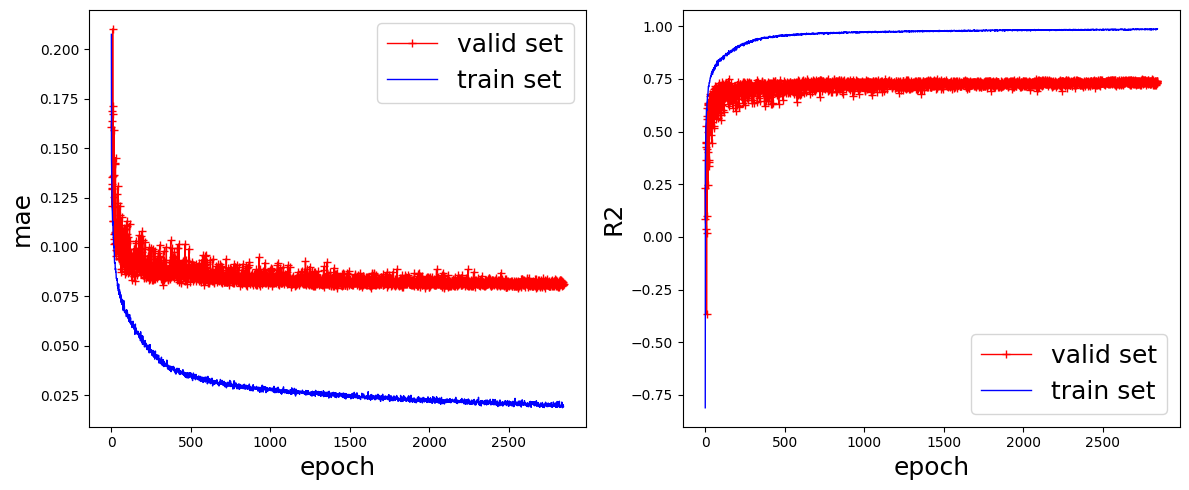

In [ ]:
path='model_ckpt/ckpt_dummy_model5'

last_ckpt_path = path + '/last_ckpt.pt'
last_ckpt = torch.load(last_ckpt_path)

error_log_train = last_ckpt['train_loss']
r2_log_train = last_ckpt['train_r2']
error_log_valid = last_ckpt['valid_loss']
r2_log_valid = last_ckpt['valid_r2'] 


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(error_log_valid, "r-+", linewidth=1, label='valid set')
axs[0].plot(error_log_train, "b-", linewidth=1, label='train set')
axs[0].set_xlabel('epoch', fontsize=18)
axs[0].set_ylabel('mae', fontsize=18)
axs[0].legend(loc='upper right', fontsize=18)

axs[1].plot(r2_log_valid, "r-+", linewidth=1, label='valid set')
axs[1].plot(r2_log_train, "b-", linewidth=1, label='train set')
axs[1].set_xlabel('epoch', fontsize=18)
axs[1].set_ylabel('R2', fontsize=18)
#axs[1].set_ylim(0, 1)
axs[1].legend(loc='lower right', fontsize=18)
#axs[1].set_ylim(-0.5, 1)


plt.tight_layout()
plt.show()

## model 불러오기

In [ ]:
path='model_ckpt/ckpt_dummy_model5'

train_loader = DataLoader(graph_train_set, batch_size=500, shuffle=True)
valid_loader = DataLoader(graph_valid_set, batch_size =500, shuffle=True)
opt_ckpt = torch.load((path + '/opt_checkpoint.pt'))

device = torch.device('cuda')
model = model_5().to(device)
model.load_state_dict(opt_ckpt['model_state_dict'])

mean = np.load('./standardization/mean.npy')
std = np.load('./standardization/std.npy')

# train
train_pred=[]
train_label=[]
train_id = []
model.eval()
with torch.no_grad(): 
    for com, elu1, elu2 in train_loader:
        train_label.append(com.y)
        train_id.append(com.sample_id)
        com_train_batch = com.to(device)
        elu1_train_batch = elu1.to(device)
        elu2_train_batch = elu2.to(device)
        pred = model(com_train_batch, elu1_train_batch, elu2_train_batch)
        train_pred.append(pred.cpu())

train_label = np.vstack(train_label)
train_label = inverse_standardization(train_label, mean, std)
train_label= train_label[:, 0].reshape(-1,1)
mask = ~np.isnan(train_label)
train_label=train_label[mask]

train_pred = np.vstack(train_pred)
train_pred = inverse_standardization(train_pred, mean, std)
train_pred = train_pred.reshape(-1,1)
train_pred=train_pred[mask]


# valid
valid_pred=[]
valid_label=[]
valid_id=[]
model.eval()
with torch.no_grad():
    for com_val, elu1_val, elu2_val in valid_loader:
        valid_label.append(com_val.y)
        valid_id.append(com_val.sample_id)
        com_valid_batch = com_val.to(device)
        elu1_valid_batch = elu1_val.to(device)
        elu2_valid_batch = elu2_val.to(device)
        pred = model(com_valid_batch, elu1_valid_batch, elu2_valid_batch)
        valid_pred.append(pred.cpu())

valid_label = np.vstack(valid_label)
valid_label = inverse_standardization(valid_label, mean, std)
valid_label= valid_label[:, 0].reshape(-1,1)
mask = ~np.isnan(valid_label)
valid_label=valid_label[mask]

valid_pred = np.vstack(valid_pred)
valid_pred = inverse_standardization(valid_pred, mean, std)
valid_pred = valid_pred.reshape(-1,1)
valid_pred=valid_pred[mask]


# test
test_pred=[]
test_label=[]
test_id=[]
model.eval()
with torch.no_grad():
    for com_test, elu1_test, elu2_test in test_loader:
        test_label.append(com_test.y)
        test_id.append(com_test.sample_id)
        com_test_batch = com_test.to(device)
        elu1_test_batch = elu1_test.to(device)
        elu2_test_batch = elu2_test.to(device)
        pred = model(com_test_batch, elu1_test_batch, elu2_test_batch)
        test_pred.append(pred.cpu())

test_label = np.vstack(test_label)
test_label = inverse_standardization(test_label, mean, std)
test_label= test_label[:, 0].reshape(-1,1)
mask = ~np.isnan(test_label)
test_label=test_label[mask]

test_pred = np.vstack(test_pred)
test_pred = inverse_standardization(test_pred, mean, std)
test_pred = test_pred.reshape(-1,1)
test_pred=test_pred[mask]


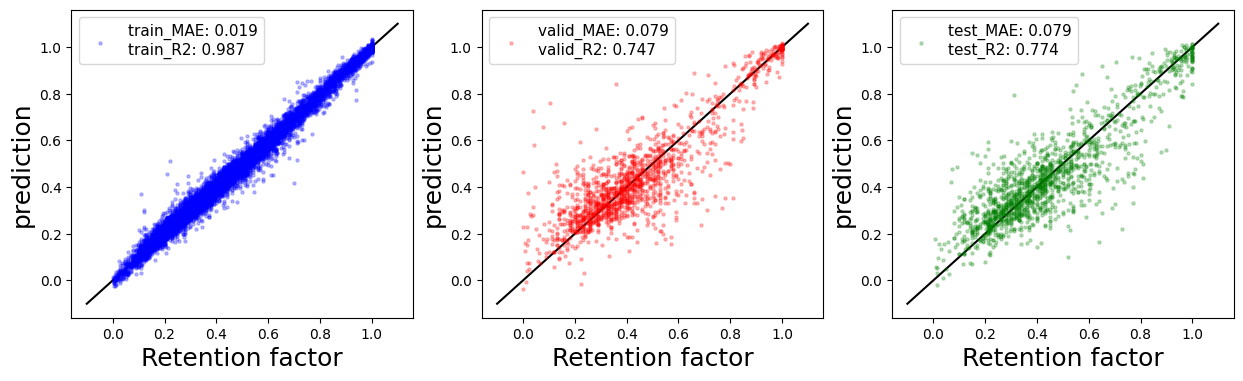

In [ ]:
# Rf 라벨일 경우

def r2(preds, targets):
    mean = np.sum(targets)/len(targets)
    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - mean) ** 2)
    return 1- ss_res / ss_tot 

train_mae = np.mean(np.abs(train_pred-train_label)).item()
valid_mae = np.mean(np.abs(valid_pred-valid_label)).item()
test_mae = np.mean(np.abs(test_pred-test_label)).item()

train_r2 = r2(train_pred, train_label).item()
valid_r2 = r2(valid_pred, valid_label).item()
test_r2 = r2(test_pred, test_label).item()


import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,3,figsize=(15,4))

x_line=np.linspace(-0.1,1.1,100)
y_line=x_line

for i in range(3):
    fig.set_facecolor('white')
    axs[i].plot(x_line, y_line, c='black', zorder=1)

    if i==0:
        axs[i].scatter(train_label.flatten(), train_pred.flatten(), c='blue',s=5, zorder=2, alpha = 0.25 , label = f'train_MAE: {round(train_mae,3)}\ntrain_R2: {round(train_r2,3)}')
    elif i==1:
        axs[i].scatter(valid_label.flatten(), valid_pred.flatten(), c='red',s=5, zorder=3, alpha = 0.25, label = f'valid_MAE: {round(valid_mae,3)}\nvalid_R2: {round(valid_r2,3)}')
    elif i==2:
        axs[i].scatter(test_label.flatten(), test_pred.flatten(), c='green',s=5, zorder=3, alpha = 0.25, label = f'test_MAE: {round(test_mae,3)}\ntest_R2: {round(test_r2,3)}')
    axs[i].set_xlabel('Retention factor', fontsize = 18)
    axs[i].set_ylabel('prediction', fontsize = 18)
    axs[i].legend(loc='upper left', fontsize = 11)
    #axs[i].set_xlim(-0.1, 1.1)
    #axs[i].set_ylim(-0.1, 1.1)

## 분석 

In [54]:
train_index = np.hstack([np.asarray(id_tensor.view(-1)) for id_tensor in train_id])
train_pred_manager = dict(zip(train_index, train_pred))

from copy import deepcopy

train_set_check = deepcopy(train_set)
train_pred_ = [train_pred_manager[i] for i in train_set['sample_id']]
train_set_check['train_pred'] = train_pred_
train_set_check['error'] = train_set_check['Rf'] - train_set_check['train_pred']
train_set_check

,Smiles,elu1_smiles,elu2_smiles,ratio1,ratio2,Rf,Rf_type,DataSource,doi,sample_id,train_pred,error
0,Br/C(=C\C1SCCCS1)c1ccccc1,CCCCCC,CCOC(C)=O,0.937438,0.062562,0.580000,C,D4C,average of several papers,0,0.565545,0.014455
1,BrC/C=C\COC1CCCCO1,CCCCCC,CCOCC,0.650419,0.349581,0.690000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.4...,2,0.699942,-0.009942
2,BrC1=C(Br)C(c2ccccc2)OC1,CCCCCC,CCOC(C)=O,0.749803,0.250197,0.780000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...,3,0.747516,0.032484
3,BrCCCCCCNc1ccccc1,CCCCCC,CCOC(C)=O,0.789299,0.210701,0.480000,C,D4C,average of several papers,6,0.493887,-0.013887
4,BrCCc1cccc2ccccc12,CCCCCC,CCOC(C)=O,0.882244,0.117756,0.630000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...,7,0.656124,-0.026124
...,...,...,...,...,...,...,...,...,...,...,...,...
11792,c1ccc(-c2ccccn2)nc1,ClCCl,CO,0.984461,0.015539,0.052081,C,benchmark,exp (benchmark,14696,0.004134,0.047947
11793,c1ccc(CNCc2ccccc2)cc1,CCCCCC,CCOCC,0.443636,0.556364,0.280306,C,benchmark,exp (benchmark,14697,0.303475,-0.023169
11794,c1ccc(CNCc2ccccc2)cc1,CCCCCC,CCOCC,0.614610,0.385390,0.185208,C,benchmark,exp (benchmark,14698,0.217972,-0.032764
11795,c1ccc2[nH]ccc2c1,CCCCCC,CCOCC,0.443636,0.556364,0.764446,C,benchmark,exp (benchmark,14699,0.735270,0.029176


In [55]:
valid_index = np.hstack([np.asarray(id_tensor.view(-1)) for id_tensor in valid_id])
valid_pred_manager = dict(zip(valid_index, valid_pred))

from copy import deepcopy
from scipy.special import softplus

valid_set_check = deepcopy(valid_set)
valid_pred_ = [valid_pred_manager[i] for i in valid_set['sample_id']]
valid_set_check['valid_pred'] = valid_pred_
valid_set_check['error'] = valid_set_check['Rf'] - valid_set_check['valid_pred']
valid_set_check

,Smiles,elu1_smiles,elu2_smiles,ratio1,ratio2,Rf,Rf_type,DataSource,doi,sample_id,valid_pred,error
0,BrC1C(Br)(Br)C12CCOCC2,CCCCC,CCOCC,0.890324,0.109676,0.500000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...,5,0.363593,0.136407
1,Brc1ccc(/C(=N\C(c2ccccc2)c2ccccc2)N2CCOCC2)cc1,CCCCCC,CCOC(C)=O,0.428314,0.571686,0.670000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.4...,16,0.483549,0.186451
2,Brc1nc2ccccc2c(Br)c1Br,CCCCCC,CCOCC,0.975532,0.024468,0.230000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...,72,0.457794,-0.227794
3,C#CC#CC(OCC#CC)c1cccc(C)c1,CCCCCC,CCOC(C)=O,0.973999,0.026001,0.380000,C,D4C,average of several papers,77,0.453877,-0.073877
4,C#CC(O)c1ccc(OC)cc1,CCCCC,CCOC(C)=O,0.772206,0.227794,0.420000,C,D4C,https://pubs.acs.org/doi/10.1021/acs.orglett.3...,94,0.404079,0.015921
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,c1cnc2c(c1)ccc1cccnc12,ClCCl,CO,0.863674,0.136326,0.103807,C,benchmark,exp (benchmark,14706,0.761688,-0.657881
1436,c1cnc2c(c1)ccc1cccnc12,ClCCl,CO,0.926851,0.073149,0.077242,C,benchmark,exp (benchmark,14707,0.656897,-0.579655
1437,c1cnc2c(c1)ccc1cccnc12,ClCCl,CO,0.950015,0.049985,0.040824,C,benchmark,exp (benchmark,14708,0.579211,-0.538387
1438,c1cnc2c(c1)ccc1cccnc12,ClCCl,CO,0.969397,0.030603,0.045959,C,benchmark,exp (benchmark,14709,0.400458,-0.354499


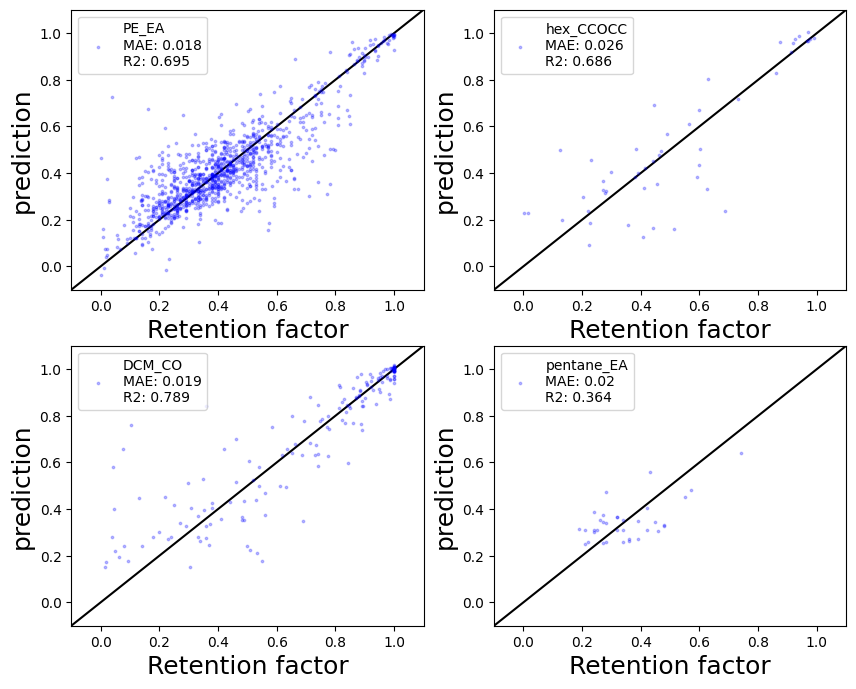

In [58]:
PE_EA_mask = [set(valid_set_check.loc[i, ['elu1_smiles','elu2_smiles']]) == {'CCOC(C)=O', 'CCCCCC'} for i in valid_set_check.index]
valid_set_check_PE_EA = valid_set_check[PE_EA_mask]

DCM_CO_mask = [set(valid_set_check.loc[i, ['elu1_smiles','elu2_smiles']]) == {'ClCCl', 'CO'} for i in valid_set_check.index]
valid_set_check_DCM_CO = valid_set_check[DCM_CO_mask]

hex_CCOCC_mask = [set(valid_set_check.loc[i, ['elu1_smiles','elu2_smiles']]) == {'CCCCCC', 'CCOCC'} for i in valid_set_check.index]
valid_set_check_hex_CCOCC = valid_set_check[hex_CCOCC_mask]

pentane_EA_mask = [set(valid_set_check.loc[i, ['elu1_smiles','elu2_smiles']]) == {'CCCCC', 'CCOC(C)=O'} for i in valid_set_check.index]
valid_set_check_pentane_EA = valid_set_check[pentane_EA_mask]

elu_sys_valid = [valid_set_check_PE_EA, valid_set_check_DCM_CO, valid_set_check_hex_CCOCC, valid_set_check_pentane_EA]
elu_sys_list = ['PE_EA', 'DCM_CO', 'hex_CCOCC', 'pentane_EA']

def mae_(preds, targets):
    return round(np.mean(np.abs(E2Rf(preds)-E2Rf(targets))), 3)

def r2(preds, targets):
    mean = np.sum(targets)/len(targets)
    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - mean) ** 2)
    return round(1- ss_res / ss_tot, 3)

    

import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,2,figsize=(10,8))

x_line=np.arange(-2,3)
y_line=np.arange(-2,3)

for i in range(4):
    fig.set_facecolor('white')
    axs[i%2, i//2].plot(x_line, y_line, c='black', zorder=1)

    axs[i%2, i//2].scatter(
        elu_sys_valid[i]['Rf'], elu_sys_valid[i]['valid_pred'],
        c='blue',s=3, zorder=2, alpha = 0.25,
        label = f'{elu_sys_list[i]}\nMAE: {mae_(elu_sys_valid[i]["valid_pred"], elu_sys_valid[i]["Rf"])}\nR2: {r2(elu_sys_valid[i]["valid_pred"], elu_sys_valid[i]["Rf"])}')
    axs[i%2, i//2].set_xlabel('Retention factor', fontsize = 18)
    axs[i%2, i//2].set_ylabel('prediction', fontsize = 18)
    axs[i%2, i//2].legend(loc='upper left', fontsize = 10)

    axs[i%2, i//2].set_xlim(-0.1, 1.1)
    axs[i%2, i//2].set_ylim(-0.1, 1.1)